# Reward curve figures for AmpC dataset

**NOTE:** This notebook assumes you have your directories organized like so
```
ROOT_DIRECTORY
├── full
│   ├── 0.001
│   │   ├── rep-0 <-- output directory of a MolPAL run
│   │  ...
│   │   └── rep-N
│   ├── 0.002
│   └── 0.004
└── prune
    ├── 0.001
    ├── 0.002
    └── 0.004
```

In [103]:
from pathlib import Path
import sys
from typing import Iterable, List, Tuple

from matplotlib import pyplot as plt, patheffects as pe, ticker
import numpy as np
import scipy.interpolate
import seaborn as sns

sys.path.append("../")
sys.path.append("../scripts/")
from scripts.experiment import Experiment
from scripts.utils import build_true_dict

sns.set_theme("talk", "white")

ROOT_DIR = Path.home() / "active-projects/molpal-pruning/runs/ampc"
SIZE = 98.2e6
k = 10000

def abbreviate_k_or_M(x: float, pos) -> str:
    if x >= 1e6:
        return f"{x*1e-6:0.1f}M"
    if x >= 1e3:
        return f"{x*1e-3:0.0f}k"

    return f"{x:0.0f}"

def pad_xss(xss: Iterable[Iterable]) -> np.ndarray:
    n = max(len(xs) for xs in xss)
    xss = [np.pad(xs, (0, n - len(xs)), constant_values=np.nan) for xs in xss]

    return np.array(xss, float)

def stack_curves(expts_dir: Path, top_k) -> np.ndarray:
    ys = []
    for p_exp in expts_dir.iterdir():
        e = Experiment(p_exp)
        ys.append(e.curve(top_k, "scores"))
    
    return pad_xss(ys)

### Step 1: get the top-$k$ points for the datasets

In [2]:
hts_scores = build_true_dict(Path.home() / "molpal/data/EnamineHTS_scores.csv")
hts_top_k = sorted(hts_scores.items(), key=lambda kv: kv[1], reverse=True)[:k]

ampc_scores = build_true_dict(Path.home() / "molpal/data/AmpC_glide_scores_top200k.csv")
ampc_top_k = sorted(ampc_scores.items(), key=lambda kv: kv[1], reverse=True)[:k]

### Step 2: Calculate the reward curve for each run, collate them, and save them to a file

*note:* only run the topmost cell if the file already exists

In [2]:
REWARD_CURVE_FULL_NPZ = "ampc_reward_curves_full-10k.npz"
REWARD_CURVE_PRUNE_NPZ = "ampc_reward_curves_prune-10k.npz"

In [19]:
SPLITS =  ("0.001", "0.002", "0.004")

Ys_full = []
Ys_prune = []
for split in SPLITS:
    Ys_full.append(stack_curves(ROOT_DIR / "full" / split, ampc_top_k))
    Ys_prune.append(stack_curves(ROOT_DIR / "prune" / split, ampc_top_k))

np.savez_compressed(REWARD_CURVE_FULL_NPZ, **dict(zip(SPLITS, Ys_full)))
np.savez_compressed(REWARD_CURVE_PRUNE_NPZ, **dict(zip(SPLITS, Ys_prune)))

### Step 3: run the cell below and call the function with your desired dataset split

In [211]:
def plot_curve(ax, Y, prune: bool = False):
    x = np.arange(Y.shape[1]) + 1

    y_mean = np.nanmean(Y, 0)
    y_sd = np.nanstd(Y, 0)

    ax.plot(
        x,
        y_mean,
        ls='dashed' if prune else 'solid',
        lw=2,
        path_effects=[pe.Stroke(linewidth=3, foreground="k"), pe.Normal()],
        label="pruning" if prune else "no pruning"
    )
    ax.fill_between(x, y_mean-y_sd, y_mean+y_sd, dashes=":", lw=1., ec="black", alpha=0.3)
    
    return ax

def plot_random_curve(ax, N):
    p = k / SIZE

    x = np.arange(N) + 1
    Y = np.cumsum(np.where(np.random.uniform(size=(10, N)) < p, 1, 0), 1) / k
    y_mean = np.nanmean(Y, 0)
    y_sd = np.nanstd(Y, 0)

    ax.plot(
        x, y_mean, color="grey", lw=2,
        path_effects=[pe.Stroke(linewidth=3, foreground="k"), pe.Normal()],
        label="random"
    )
    ax.fill_between(
        x, y_mean-y_sd, y_mean+y_sd, color="grey", dashes=":", lw=1., ec="black", alpha=0.3
    )

    return ax

def plot_reward(ax, split: str):
    sns.set_palette("dark")

    full_npz = np.load(REWARD_CURVE_FULL_NPZ)
    prune_npz = np.load(REWARD_CURVE_PRUNE_NPZ)

    Y_full = full_npz[split]
    Y_prune = prune_npz[split]

    plot_curve(ax, Y_full[:, :Y_prune.shape[1]], False)
    plot_curve(ax, Y_prune, True)
    plot_random_curve(ax, Y_prune.shape[1])

    mask = ~np.isnan(Y_prune)
    i_stop = np.argmin(mask, 1)
    i_stop = i_stop[i_stop > 0]
    if len(i_stop) > 0:
        ax.axvspan(i_stop.min(), Y_prune.shape[1], color="grey", alpha=0.2)
    
    ax.set_ylim(-0.05, 1.05)
    formatter = ticker.FuncFormatter(abbreviate_k_or_M)
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis="x", which="major", bottom=True, rotation=20)

    ax.grid(True, ls="--")

    ax.set_xlabel("Molecules explored")
    ax.set_ylabel(f"Fraction of Top-10000 Scores Found")
    ax.legend()

    return ax

In [212]:
def retained_idxss(expt: Experiment) -> List[np.ndarray]:
    return [np.load(chkpt / "retained_idxs.npy") for chkpt in expt.chkpts[:-1]]

def gcp_dollars(cpus: float = 0., gpus: float = 0) -> float:
    return cpus * 0.0475/60**2 + gpus * 2.48/60**2
    
def cost_curve(expt: Experiment, prune: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    n_tr = np.array(expt.num_acquired)[:-1]
    c_tr = n_tr * 6.16 / 400e3

    if prune:
        s = [SIZE]
        for I in retained_idxss(expt)[:-1]:
            s.append(len(I))
        n_pred = np.array(s)
        c_pred = n_pred * 20.52 / 98.2e6
    else:
        c_pred = 20.52 * (np.ones(expt.num_iters - 1))

    return n_tr, np.cumsum(c_pred + c_tr)

def align_cost_curves(X: np.ndarray, C_prune):
    x_new = X.max(0)
    C_prune_new = np.empty(C_prune.shape)

    for i, (x, c) in enumerate(zip(X, C_prune)):
        f = scipy.interpolate.interp1d(
            x, c, "previous", bounds_error=False, fill_value="extrapolate"
        )
        C_prune_new[i] = f(x_new)
        
    return C_prune_new

In [213]:
def plot_cost(ax, split):
    sns.set_palette("dark")

    p = ROOT_DIR / "full" / split / "rep-0"
    x_full, c_full = cost_curve(Experiment(p), False)

    d_ampc_prune = ROOT_DIR / "prune"

    x_min, x_max = np.inf, -np.inf
    prune_curves = []
    for p_exp in (d_ampc_prune / split).iterdir():
        e = Experiment(p_exp)
        prune_curves.append(cost_curve(e, True))

        N_a_max = max(e.num_acquired)
        x_min = min(x_min, N_a_max)
        x_max = max(x_max, N_a_max)
        
    xs, prune_costs = zip(*prune_curves)
    X = np.array(xs)
    C_prune_new = align_cost_curves(X, np.array(prune_costs))

    mask = x_full < x_max #x_new[-1]
    x_full = x_full[mask]
    c_full = c_full[mask]

    lines = ax.plot(
        x_full, c_full, 'o',
        mec='k', mew=2, label="no pruning"
    )
    ax.step(
        [0, *x_full, x_max], [0, *c_full, c_full[-1]], '-', where="post",
        color=lines[0].get_color()
    )

    x = X.min(0)
    ebars = ax.errorbar(
        x, C_prune_new.mean(0), yerr=C_prune_new.std(0), fmt='o',
        mec='k', mew=2, capsize=5, label="pruning"
    )
    ax.step(
        [0, *x, x_max], [0, *C_prune_new.mean(0), C_prune_new.mean(0)[-1]], '--', 
        where="post", color=ebars.lines[0].get_color()
    )

    ax.axvspan(x_min, x_max, color="grey", alpha=0.2)
    
    ax.set_xlabel("Molecules Explored")
    ax.set_ylabel("Overhead Cost / $")
    ax.grid(True, ls="--")

    formatter = ticker.FuncFormatter(abbreviate_k_or_M)
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis="x", rotation=20)
    
    return ax

Text(0.575, 0.962, 'B')

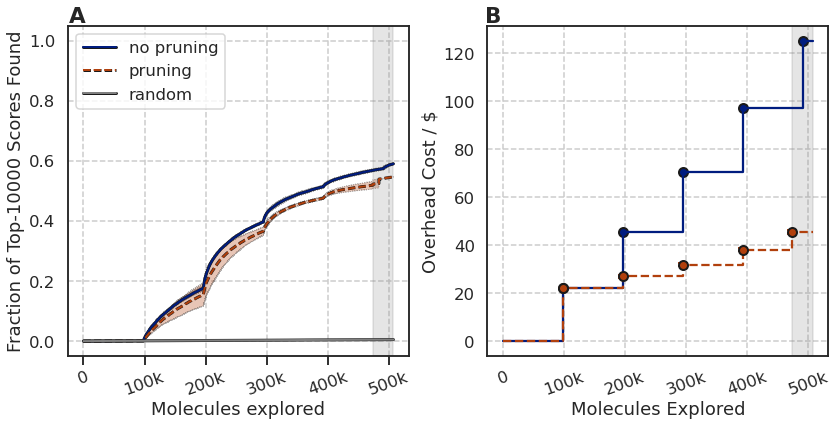

In [231]:
split = "0.001"

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
plot_reward(axs[0], split)
plot_cost(axs[1], split)

fig.tight_layout()
fig.subplots_adjust(wspace=0.23)

fig.text(0.094, 0.962, "A", size="large", weight="bold")
fig.text(0.575, 0.962, "B", size="large", weight="bold")

In [229]:
fig.savefig(f"../figures/ampc-{split[2:]}-curves+cost-10k.png", dpi=400)

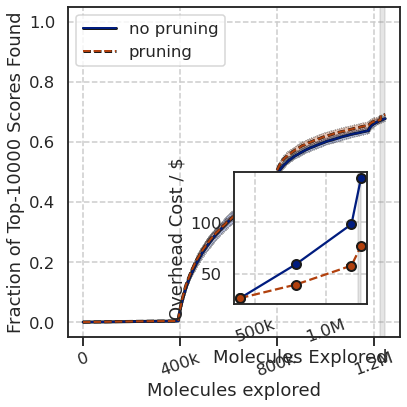

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_reward(ax, "0.004")
axin1 = ax.inset_axes((0.5, 0.1, 0.4, 0.4))
plot_cost(axin1, "0.004")
fig.tight_layout()

In [54]:
d_ampc_prune = ROOT_DIR / "prune"

split = "0.002"

xss = []
prune_costs = []
for p_exp in (d_ampc_prune / split).iterdir():
    e = Experiment(p_exp)

    xss.append(np.array(e.num_acquired, float))
    prune_costs.append(np.cumsum(cost_curve(e, True)))

X = pad_xss(xss)
C_prune = np.array(prune_costs)

In [119]:
SIZE * 0.002 * 4

785600.0

In [105]:
p

0.00010183299389002037